This notebook tunes and fits a neural network to the processed COGS data. It may be edited and adjusted to construct new tuners or network architectures. All new tuners should be created in the "Case 1: Build a Tuner from Scratch" section and as soon as the tuner is found to work, the construct_model function and the reload statement should be moved to Case 2 where they should no longer be edited in case they are to be used again.

The notebook is based a commented version of my ***(Do not edit) working NN, all files with automatic Hyperparameter Tuning 104 MAE.ipynb*** notebook, adjusted to make it easier to understand.

❗❗❗ Note: make sure to increase the runtime to High-RAM 24Gb and use GPU for fast training of the model

## **Imports and Installing**

Install Keras Tuner - an automatic hyperparameter tuner - using pip

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 4.3 MB/s 
     |████████████████████████████████| 1.6 MB 30.8 MB/s 


Import the necessary python libraries

In [ ]:
from netCDF4 import Dataset
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import csv
from datetime import datetime
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import PIL
import warnings
from csv import writer
from scipy import ndimage as nd
import random


from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

⬛*Run the following cell only if keras tuner has been installed, to import it*

In [ ]:
import keras_tuner as kt

Set the seed for reproducibility

In [ ]:
random.seed(908)

## **Connect to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


## **Compiling the Training Vectors**

⬛*Run the following section only if you want to reconstruct the variables on a new machine - otherwise just load in from the drive*

In [ ]:
def compile_variables():
      #store the file path for the list of all COGS files in chronological order
      file_list_csv = "/content/gdrive/MyDrive/Colab Notebooks/Data/processing_file_list_ignoring5files.csv"
      #use pandas to read in the file list csv file and iterate through them
      df = pd.read_csv(file_list_csv)
      cloud_perimeter = np.array([0.5,0.5])
      cloud_fraction = np.array([0.5,0.5])
      height = np.array([1,1])
      for row_index, filename in df.iterrows():
            filename_str=str(filename['File_names'])
            #specify the directories of the data files
            new_file_path_perimeter="/content/gdrive/MyDrive/Colab Notebooks/Data/Variables/Cloud Perimeter/"
            new_file_path_fraction="/content/gdrive/MyDrive/Colab Notebooks/Data/Variables/Cloud Fraction/"
            new_file_path_height="/content/gdrive/MyDrive/Colab Notebooks/Data/Variables/Height/"
            #specify the path to the next data file
            new_file_name_perimeter=new_file_path_perimeter+"Perimeter_"+filename_str[1:-5]+".csv"
            new_file_name_fraction=new_file_path_fraction+"Fraction_"+filename_str[1:-5]+".csv"
            new_file_name_height=new_file_path_height+"Height_"+filename_str[1:-5]+".csv"
            #read in the csv file
            perimeter_df = pd.read_csv(new_file_name_perimeter, header=None)
            # then convert to numpy array of floats
            perimeter_df = perimeter_df.to_numpy()
            #repeat for the other two variables
            fraction_df = pd.read_csv(new_file_name_fraction, header=None)
            height_df = pd.read_csv(new_file_name_height, header=None)
            # then convert to numpy array of floats/integers
            fraction_df = fraction_df.to_numpy()
            height_df = height_df.to_numpy(dtype='i')
            perimeter_df = perimeter_df.reshape(len(perimeter_df))
            fraction_df = fraction_df.reshape(len(fraction_df))
            height_df = height_df.reshape(len(height_df))
            cloud_fraction_mask = fraction_df > 0
            #mask the dataframe arrays with the cloud fraction mask
            perimeter_df=perimeter_df[cloud_fraction_mask]
            fraction_df=fraction_df[cloud_fraction_mask]
            height_df=height_df[cloud_fraction_mask]
            # concatenate the new vectors with the existing vectors
            cloud_perimeter = np.concatenate((cloud_perimeter,perimeter_df),axis=0)
            cloud_fraction = np.concatenate((cloud_fraction,fraction_df),axis=0)
            height = np.concatenate((height,height_df),axis=0)
            del perimeter_df
            del fraction_df
            del height_df


            #now work on the atmospheric data
            #specify the file path
            new_file_path_atmospheric = "/content/gdrive/MyDrive/Colab Notebooks/Data/Variables/Atmospheric/"
            new_file_name_atmospheric = new_file_path_atmospheric + "Atmospheric_"+filename_str[1:-5]+".npy"
            #load in the numpy array
            atmospheric_file = np.load(new_file_name_atmospheric)
            atmospheric_file = atmospheric_file[cloud_fraction_mask,:,:]
            variable_mask = [True,True,True,True,True,True,True,True,True,True]
            atmospheric_file = atmospheric_file[:,:,variable_mask]
            #if it's the first file set this to be the array itself
            if row_index == 0:
                  atmospheric_variables = atmospheric_file
            else:
                  atmospheric_variables = np.concatenate((atmospheric_variables,atmospheric_file),axis=0)
            del atmospheric_file
            print(row_index)

      cloud_perimeter = cloud_perimeter[2:]
      cloud_fraction = cloud_fraction[2:]
      height = height[2:]
      cloud_perimeter = cloud_perimeter.reshape(len(cloud_perimeter),1)
      cloud_fraction = cloud_fraction.reshape(len(cloud_fraction),1)
      height = height.reshape(len(height),1)
      return cloud_perimeter, cloud_fraction, height, atmospheric_variables

Construct the variables using the defined function and assert that the variables are of the correct shape. Also un-normalise the cloud perimeter variables in order to retain the dynamic range of the data

In [ ]:
#construct the variables
cloud_perimeter, cloud_fraction, height, atmospheric_variables = compile_variables()
#print the shapes of the variables
print(cloud_perimeter.shape)
print(cloud_fraction.shape)
print(height.shape)
#un-normalise cloud perimeter
cloud_perimeter = cloud_perimeter * 16200
#assert the shapes match
print(atmospheric_variables.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
(1767636, 1)
(1767636, 1)
(1767636, 1)
(1767636, 332, 10)


In [ ]:
print(cloud_perimeter)

[[ 218.]
 [1277.]
 [ 528.]
 ...
 [  17.]
 [   5.]
 [   9.]]


Define a path to save the newly constructed variables

In [ ]:
new_file_directory = '/content/gdrive/MyDrive/Colab Notebooks/Data/Variables/Training Arrays/'

In [ ]:
#save the newly constructred variables
np.save(new_file_directory+'Perimeter',cloud_perimeter)
np.save(new_file_directory+'Height',height)
np.save(new_file_directory+'Fraction',cloud_fraction)
np.save(new_file_directory+'Atmospheric',atmospheric_variables)

Delete the variables to save RAM

In [ ]:
del atmospheric_variables
del cloud_perimeter
del height
del cloud_fraction

# **Method 0: Fitting an Overparametrised Model**

## **Load in the Data**

Define the path to access the saved arrays

In [ ]:
new_file_directory = '/content/gdrive/MyDrive/Colab Notebooks/Data/Variables/Training Arrays/'

Load in the saved arrays into variables and assert the shapes are correct

In [ ]:
atmospheric_variables = np.load(new_file_directory+'Atmospheric.npy')
cloud_perimeter = np.load(new_file_directory+'Perimeter.npy')
height = np.load(new_file_directory+'Height.npy')
cloud_fraction = np.load(new_file_directory+'Fraction.npy')
print(cloud_perimeter.shape)
print(cloud_fraction.shape)
print(height.shape)
print(atmospheric_variables.shape)

(1767636, 1)
(1767636, 1)
(1767636, 1)
(1767636, 332, 10)


We do not require all atmospheric variables or height levels. Hence we create masks to reduce the atmospheric variables array to the appropriate indices

In [ ]:
#take only the first 10 height levels
atmospheric_variables = atmospheric_variables[:,:7,:]
#take only 4 of the atmospheric variables
variable_mask = [True,False,False,True,True,False,False,False,True,False]
atmospheric_variables = atmospheric_variables[:,:,variable_mask]
#print the new shape of atmospheric variables
print(atmospheric_variables.shape)

(1767636, 7, 4)


## **Construct the Model (Manually)**

In [ ]:
def construct_model(height_levels,num_channels,num_scalar_variables):
      #define the two inputs for the two heads of the network
      inputA=Input(shape=(height_levels,num_channels))
      inputB=Input(shape=(1,num_scalar_variables))

      #define the convolutional layers acting on inputA
      a=Conv1D(filters=128,kernel_size=3,padding='same',activation='relu')(inputA)
      a=MaxPooling1D(pool_size=1, padding='same')(a)
      a=Conv1D(filters=128,kernel_size=3,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=1, padding='same')(a)
      a=Conv1D(filters=128,kernel_size=3,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=1, padding='same')(a)
      a=Conv1D(filters=128,kernel_size=3,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=1, padding='same')(a)
      a=Conv1D(filters=128,kernel_size=3,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=1, padding='same')(a)
      a=Flatten()(a)
      a=Model(inputs=inputA, outputs=a)

      #define the other head of the network for inputB
      b=Flatten()(inputB)
      b=Dense(4)(b)
      b=Dense(128)(b)
      b=Dense(128)(b)
      b=Dense(128)(b)
      b=Dense(4)(b)
      b=Model(inputs=inputB, outputs=b)

      #combine the heads of the network
      combined_vector = concatenate([a.output, b.output])
      z=Dense(128, activation="relu")(combined_vector)
      z=Dropout(0.3)(z)
      z=Dense(256, activation="relu")(combined_vector)
      z=Dropout(0.3)(z)
      z=Dense(2048, activation="relu")(combined_vector)
      z=Dropout(0.3)(z)
      z=Dense(2048, activation="relu")(combined_vector)
      z=Dropout(0.3)(z)
      z=Dense(2048, activation="relu")(combined_vector)
      z=Dropout(0.3)(z)
      z=Dense(2048, activation="relu")(combined_vector)
      z=Dropout(0.3)(z)
      z=Dense(2048, activation="relu")(combined_vector)
      z=Dropout(0.3)(z)
      z=Dense(256, activation="relu")(z)
      z=Dropout(0.3)(z)
      z=Dense(256, activation="relu")(z)
      z=Dropout(0.3)(z)
      z=Dense(256, activation="relu")(z)
      z=Dropout(0.3)(z)
      z=Dense(128, activation="relu")(z)
      z=Dropout(0.3)(z)
      z=Dense(16, activation="relu")(z)
      z=Dropout(0.1)(z)
      z=Dense(1)(z)

      #finally define the outputs
      model=Model(inputs=[inputA,inputB], outputs=z)

      opt_choice=keras.optimizers.Adam(learning_rate=0.001)
      model.compile(optimizer=opt_choice,loss="mse",metrics=['mae'])

      model.summary()
      keras.utils.plot_model(model, "double-headed CNN.png", show_shapes=True)
      return model

In [ ]:
def train_val_test_split(atmospheric_variables,cloud_fraction,height,cloud_perimeter):
      #check that the number of data points agree for all variables
      assert atmospheric_variables.shape[0]==cloud_fraction.shape[0] and \
      atmospheric_variables.shape[0]==height.shape[0] \
      and atmospheric_variables.shape[0]==cloud_perimeter.shape[0]

      num_data_points = int(atmospheric_variables.shape[0])
       
      #define the shuffling permutation and shuffle the variables in unison
      perm = np.random.permutation(num_data_points)
      atmospheric_variables = atmospheric_variables[perm,:,:]
      cloud_fraction = cloud_fraction[perm,:]
      height = height[perm,:]
      cloud_perimeter = cloud_perimeter[perm,:]

      #combine the height and cloud fraction variables
      x2=np.stack((cloud_fraction,height),axis=2)

      #compute the training set size
      train_size=int(np.floor(0.7*num_data_points))
      val_size=int(np.floor(0.85*num_data_points))

      #specify the train, test and validation sets
      #split the data into train and test
      x1_train=atmospheric_variables[:train_size,:,:]
      x2_train=x2[:train_size,:,:]
      y_train=cloud_perimeter[:train_size,:]
      #
      x1_val=atmospheric_variables[train_size:val_size,:,:]
      x2_val=x2[train_size:val_size,:,:]
      y_val=cloud_perimeter[train_size:val_size,:]
      #
      x1_test=atmospheric_variables[val_size:,:,:]
      x2_test=x2[val_size:,:,:]
      y_test=cloud_perimeter[val_size:,:]

      return x1_train, x2_train, y_train, x1_val, x2_val, y_val, x1_test, x2_test, y_test

Construct the train, validation and test sets using the function above. Also, construct the model using the function construct_model, ready for it to be trained. The shape command is used to find the relevant parameters to input into the function.

In [ ]:
#find the parameters necessary
height_dimensions = atmospheric_variables.shape[1]
num_channels = atmospheric_variables.shape[2]
#construct the model and print a model summary
model = construct_model(height_dimensions,num_channels,2)
#define the train, validation and test sets
x1_train, x2_train, y_train, x1_val, x2_val, y_val, x1_test, x2_test, y_test = train_val_test_split(atmospheric_variables,cloud_fraction,height,cloud_perimeter)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 7, 4)]       0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 7, 128)       1664        ['input_5[0][0]']                
                                                                                                  
 max_pooling1d_10 (MaxPooling1D  (None, 7, 128)      0           ['conv1d_10[0][0]']              
 )                                                                                                
                                                                                                  
 conv1d_11 (Conv1D)             (None, 7, 128)       49280       ['max_pooling1d_10[0][0]'] 

Delete the variables to save RAM

In [ ]:
del atmospheric_variables
del cloud_fraction
del height
del cloud_perimeter

In [ ]:
#print the shape of x2_test as a sanity check
print(x2_test.shape)

(265146, 1, 2)


Now fit the model:

In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 7, 4)]       0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 7, 128)       1664        ['input_5[0][0]']                
                                                                                                  
 max_pooling1d_10 (MaxPooling1D  (None, 7, 128)      0           ['conv1d_10[0][0]']              
 )                                                                                                
                                                                                                  
 conv1d_11 (Conv1D)             (None, 7, 128)       49280       ['max_pooling1d_10[0][0]'] 

In [ ]:
adaptive_learning = True

if adaptive_learning:
      def adapt_learning_rate(epoch):
          power = epoch // 20
          multiplier = 0.1 ** power
          if epoch < 60: 
            lr = 0.002 * multiplier
          else:
            lr = 2e-5
          return lr
      my_lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate)
      
if adaptive_learning:
      history = model.fit(x=[x1_train,x2_train], y=y_train, validation_data=([x1_val,x2_val], y_val), epochs=200, batch_size=2048, shuffle=True, callbacks=[my_lr_scheduler])
else:
      history = model.fit(x=[x1_train,x2_train], y=y_train, validation_data=([x1_val,x2_val], y_val), epochs=200, batch_size=2048, shuffle=True)


Epoch 1/200
605/605 [==============================] - 22s 34ms/step - loss: 199979.0312 - mae: 254.1348 - val_loss: 96210.2109 - val_mae: 165.9990 - lr: 0.0020
Epoch 2/200
605/605 [==============================] - 20s 33ms/step - loss: 79386.1094 - mae: 159.0105 - val_loss: 115029.3203 - val_mae: 200.4100 - lr: 0.0020
Epoch 3/200
605/605 [==============================] - 20s 33ms/step - loss: 73781.2188 - mae: 152.1143 - val_loss: 164676.6406 - val_mae: 241.0851 - lr: 0.0020
Epoch 4/200
605/605 [==============================] - 20s 33ms/step - loss: 70408.1406 - mae: 146.7034 - val_loss: 203256.1875 - val_mae: 251.1448 - lr: 0.0020
Epoch 5/200
605/605 [==============================] - 20s 33ms/step - loss: 67837.7109 - mae: 143.8819 - val_loss: 189527.6875 - val_mae: 261.6770 - lr: 0.0020
Epoch 6/200
605/605 [==============================] - 20s 33ms/step - loss: 66215.8750 - mae: 142.3295 - val_loss: 213956.2500 - val_mae: 280.0861 - lr: 0.0020
Epoch 7/200
605/605 [=============

KeyboardInterrupt: ignored

# **Method 1: Fitting a Model with Manual Hyperparameter Selection**

## **Load in the Data**

Define the path to access the saved arrays

In [ ]:
new_file_directory = '/content/gdrive/MyDrive/Colab Notebooks/Data/Variables/Training Arrays/'

Load in the saved arrays into variables and assert the shapes are correct

In [ ]:
atmospheric_variables = np.load(new_file_directory+'Atmospheric.npy')
cloud_perimeter = np.load(new_file_directory+'Perimeter.npy')
height = np.load(new_file_directory+'Height.npy')
cloud_fraction = np.load(new_file_directory+'Fraction.npy')
print(cloud_perimeter.shape)
print(cloud_fraction.shape)
print(height.shape)
print(atmospheric_variables.shape)

(1767636, 1)
(1767636, 1)
(1767636, 1)
(1767636, 332, 10)


We do not require all atmospheric variables or height levels. Hence we create masks to reduce the atmospheric variables array to the appropriate indices

In [ ]:
#take only the first 10 height levels
atmospheric_variables = atmospheric_variables[:,:10,:]
#take only 4 of the atmospheric variables
variable_mask = [True,False,False,True,True,False,False,False,True,False]
atmospheric_variables = atmospheric_variables[:,:,variable_mask]
#print the new shape of atmospheric variables
print(atmospheric_variables.shape)

(1767636, 10, 4)


## **Construct the Model (Manually)**

In [ ]:
def construct_model(height_levels,num_channels,num_scalar_variables):
      #define the two inputs for the two heads of the network
      inputA=Input(shape=(height_levels,num_channels))
      inputB=Input(shape=(1,num_scalar_variables))

      #define the convolutional layers acting on inputA
      a=Conv1D(filters=8,kernel_size=3,padding='same',activation='relu')(inputA)
      a=MaxPooling1D(pool_size=2, padding='same')(a)
      a=Conv1D(filters=16,kernel_size=3,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=2, padding='same')(a)
      a=Conv1D(filters=32,kernel_size=3,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=2, padding='same')(a)
      a=Flatten()(a)
      a=Model(inputs=inputA, outputs=a)

      #define the other head of the network for inputB
      b=Flatten()(inputB)
      b=Dense(4)(b)
      b=Model(inputs=inputB, outputs=b)

      #combine the heads of the network
      combined_vector = concatenate([a.output, b.output])
      z=Dense(256, activation="relu")(combined_vector)
      z=Dropout(0.1)(z)
      z=Dense(256, activation="relu")(z)
      z=Dropout(0.1)(z)
      z=Dense(16, activation="relu")(z)
      z=Dropout(0.1)(z)
      z=Dense(1)(z)

      #finally define the outputs
      model=Model(inputs=[inputA,inputB], outputs=z)

      opt_choice=keras.optimizers.Adam(learning_rate=0.001)
      model.compile(optimizer=opt_choice,loss="mse",metrics=['mae'])

      model.summary()
      keras.utils.plot_model(model, "double-headed CNN.png", show_shapes=True)
      return model

In [ ]:
def train_val_test_split(atmospheric_variables,cloud_fraction,height,cloud_perimeter):
      #check that the number of data points agree for all variables
      assert atmospheric_variables.shape[0]==cloud_fraction.shape[0] and \
      atmospheric_variables.shape[0]==height.shape[0] \
      and atmospheric_variables.shape[0]==cloud_perimeter.shape[0]

      num_data_points = int(atmospheric_variables.shape[0])
       
      #define the shuffling permutation and shuffle the variables in unison
      perm = np.random.permutation(num_data_points)
      atmospheric_variables = atmospheric_variables[perm,:,:]
      cloud_fraction = cloud_fraction[perm,:]
      height = height[perm,:]
      cloud_perimeter = cloud_perimeter[perm,:]

      #combine the height and cloud fraction variables
      x2=np.stack((cloud_fraction,height),axis=2)

      #compute the training set size
      train_size=int(np.floor(0.7*num_data_points))
      val_size=int(np.floor(0.85*num_data_points))

      #specify the train, test and validation sets
      #split the data into train and test
      x1_train=atmospheric_variables[:train_size,:,:]
      x2_train=x2[:train_size,:,:]
      y_train=cloud_perimeter[:train_size,:]
      #
      x1_val=atmospheric_variables[train_size:val_size,:,:]
      x2_val=x2[train_size:val_size,:,:]
      y_val=cloud_perimeter[train_size:val_size,:]
      #
      x1_test=atmospheric_variables[val_size:,:,:]
      x2_test=x2[val_size:,:,:]
      y_test=cloud_perimeter[val_size:,:]

      return x1_train, x2_train, y_train, x1_val, x2_val, y_val, x1_test, x2_test, y_test

Construct the train, validation and test sets using the function above. Also, construct the model using the function construct_model, ready for it to be trained. The shape command is used to find the relevant parameters to input into the function.

In [ ]:
#find the parameters necessary
height_dimensions = atmospheric_variables.shape[1]
num_channels = atmospheric_variables.shape[2]
#construct the model and print a model summary
model = construct_model(height_dimensions,num_channels,2)
#define the train, validation and test sets
x1_train, x2_train, y_train, x1_val, x2_val, y_val, x1_test, x2_test, y_test = train_val_test_split(atmospheric_variables,cloud_fraction,height,cloud_perimeter)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 10, 4)]      0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 10, 8)        104         ['input_5[0][0]']                
                                                                                                  
 max_pooling1d_6 (MaxPooling1D)  (None, 5, 8)        0           ['conv1d_6[0][0]']               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 5, 16)        400         ['max_pooling1d_6[0][0]']        
                                                                                            

Delete the variables to save RAM

In [ ]:
del atmospheric_variables
del cloud_fraction
del height
del cloud_perimeter

In [ ]:
#print the shape of x2_test as a sanity check
print(x2_test.shape)

(265146, 1, 2)


Now fit the model:

In [ ]:
opt_choice=keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt_choice,loss="mse",metrics=['mae'])

history = model.fit(x=[x1_train,x2_train], y=y_train, validation_data=([x1_val,x2_val], y_val), epochs=200, batch_size=2048, shuffle=True)

Epoch 1/200
605/605 [==============================] - 5s 7ms/step - loss: 58075.0625 - mae: 130.2879 - val_loss: 45311.8984 - val_mae: 112.7336
Epoch 2/200
605/605 [==============================] - 4s 6ms/step - loss: 57151.4727 - mae: 129.3902 - val_loss: 43389.5742 - val_mae: 110.5048
Epoch 3/200
605/605 [==============================] - 4s 6ms/step - loss: 56787.4297 - mae: 128.8779 - val_loss: 44082.0859 - val_mae: 113.5985
Epoch 4/200
605/605 [==============================] - 4s 6ms/step - loss: 56566.3164 - mae: 128.5934 - val_loss: 42922.6367 - val_mae: 107.9373
Epoch 5/200
605/605 [==============================] - 4s 6ms/step - loss: 56211.0195 - mae: 127.7231 - val_loss: 43310.1680 - val_mae: 109.7689
Epoch 6/200
605/605 [==============================] - 3s 6ms/step - loss: 55575.9531 - mae: 126.8107 - val_loss: 40801.0117 - val_mae: 105.6693
Epoch 7/200
605/605 [==============================] - 3s 6ms/step - loss: 55248.5742 - mae: 126.8511 - val_loss: 43311.4258 - val

# **Method 2: Fitting a Model with Automatic Hyperparameter Selection**

Define the path to access the saved arrays

In [ ]:
new_file_directory = '/content/gdrive/MyDrive/Colab Notebooks/Data/Variables/Training Arrays/'

Load in the saved arrays into variables and assert the shapes are correct

In [ ]:
atmospheric_variables = np.load(new_file_directory+'Atmospheric.npy')
cloud_perimeter = np.load(new_file_directory+'Perimeter.npy')
height = np.load(new_file_directory+'Height.npy')
cloud_fraction = np.load(new_file_directory+'Fraction.npy')
print(cloud_perimeter.shape)
print(cloud_fraction.shape)
print(height.shape)
print(atmospheric_variables.shape)

(1767636, 1)
(1767636, 1)
(1767636, 1)
(1767636, 332, 10)


In [ ]:
print(cloud_perimeter)

[[ 218.]
 [1277.]
 [ 528.]
 ...
 [  17.]
 [   5.]
 [   9.]]


We do not require all atmospheric variables or height levels. Hence we create masks to reduce the atmospheric variables array to the appropriate indices

In [ ]:
#take only the first 10 height levels
atmospheric_variables = atmospheric_variables[:,:7,:]
#take only 4 of the atmospheric variables
variable_mask = [True,False,False,True,True,False,False,False,True,False]
atmospheric_variables = atmospheric_variables[:,:,variable_mask]
#print the new shape of atmospheric variables
print(atmospheric_variables.shape)

(1767636, 7, 4)


Define functions to construct the model and create the train, validation and test sets. Use the parameter hp (for hyperparameter) which is required by keras tuner

In [ ]:
def train_val_test_split(atmospheric_variables,cloud_fraction,height,cloud_perimeter):
      #check that the number of data points agree for all variables
      assert atmospheric_variables.shape[0]==cloud_fraction.shape[0] and \
      atmospheric_variables.shape[0]==height.shape[0] \
      and atmospheric_variables.shape[0]==cloud_perimeter.shape[0]

      num_data_points = int(atmospheric_variables.shape[0])
       
      #define the shuffling permutation and shuffle the variables in unison
      perm = np.random.permutation(num_data_points)
      atmospheric_variables = atmospheric_variables[perm,:,:]
      cloud_fraction = cloud_fraction[perm,:]
      height = height[perm,:]
      cloud_perimeter = cloud_perimeter[perm,:]

      #combine the height and cloud fraction variables
      x2=np.stack((cloud_fraction,height),axis=2)

      #compute the training set size
      train_size=int(np.floor(0.7*num_data_points))
      val_size=int(np.floor(0.85*num_data_points))

      #specify the train, test and validation sets
      #split the data into train and test
      x1_train=atmospheric_variables[:train_size,:,:]
      x2_train=x2[:train_size,:,:]
      y_train=cloud_perimeter[:train_size,:]
      #
      x1_val=atmospheric_variables[train_size:val_size,:,:]
      x2_val=x2[train_size:val_size,:,:]
      y_val=cloud_perimeter[train_size:val_size,:]
      #
      x1_test=atmospheric_variables[val_size:,:,:]
      x2_test=x2[val_size:,:,:]
      y_test=cloud_perimeter[val_size:,:]

      return x1_train, x2_train, y_train, x1_val, x2_val, y_val, x1_test, x2_test, y_test

In [ ]:
x1_train, x2_train, y_train, x1_val, x2_val, y_val, x1_test, x2_test, y_test = train_val_test_split(atmospheric_variables,cloud_fraction,height,cloud_perimeter)

In [ ]:
print(x2_test.shape)

(265146, 1, 2)


Delete the variables to save RAM

In [ ]:
del atmospheric_variables
del cloud_fraction
del height
del cloud_perimeter

#### **Case 1: Define the Tuner from Scratch**

⬛Run this section only if you wish to do the tuning from scratch rather than load in a saved tuner

❗❗❗Note: adjust the (10,4) shape to be appropriate to the shape of the atmospheric_variables that has been defined in the previous cell (when only certain variables and height levels were chosen)

In [ ]:
def construct_model(hp):
      #define the two inputs for the two heads of the network
      inputA=Input(shape=(7,4))
      inputB=Input(shape=(1,2))

      hp_kernel = hp.Choice('kernel_size', values = [1,2,3,4,5,6])
      hp_pool = hp.Choice('pool_size', values = [1,2,3,4])
      #define the convolutional layers acting on inputA
      a=Conv1D(filters=8,kernel_size=hp_kernel,padding='same',activation='relu')(inputA)
      a=MaxPooling1D(pool_size=hp_pool, padding='same')(a)
      a=Conv1D(filters=16,kernel_size=hp_kernel,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=hp_pool, padding='same')(a)
      a=Conv1D(filters=32,kernel_size=hp_kernel,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=hp_pool, padding='same')(a)
      a=Conv1D(filters=32,kernel_size=hp_kernel,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=hp_pool, padding='same')(a)
      a=Flatten()(a)
      a=Model(inputs=inputA, outputs=a)

      #define the other head of the network for inputB
      b=Flatten()(inputB)
      b=Dense(4)(b)
      b=Model(inputs=inputB, outputs=b)

      #combine the heads of the network
      hp_units_z1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
      hp_units_z2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
      hp_units_z3 = hp.Int('units_3', min_value=16, max_value=256, step=16)
      hp_units_z4 = hp.Int('units_4', min_value=16, max_value=128, step=16)
      hp_dropout = hp.Choice('dropout', values = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])

      combined_vector = concatenate([a.output, b.output])
      z=Dense(units=hp_units_z1, activation="relu")(combined_vector)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z2, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z3, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z4, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(1)(z)

      #finally define the outputs
      model=Model(inputs=[inputA,inputB], outputs=z)


      hp_learning_rate = 0.001
      opt_choice=keras.optimizers.Adam(learning_rate=hp_learning_rate)
      model.compile(optimizer=opt_choice,loss="mse",metrics=['mae'])

      return model

In [ ]:
def adapt_learning_rate(epoch):
          power = epoch // 20
          multiplier = 0.1 ** power
          if epoch < 60: 
            lr = 0.002 * multiplier
          else:
            lr = 2e-5
          return lr
my_lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate)

In [ ]:
tuner = kt.Hyperband(construct_model,
                     objective='val_mae',
                     max_epochs=200,
                     directory='/content/gdrive/MyDrive/Colab Notebooks/Tuning',
                     project_name='RoundingFixed_Hyperband_Tuner_allfiles_more_epochs')

In [ ]:
tuner.search(x=[x1_train,x2_train], y=y_train, validation_data=([x1_val,x2_val], y_val), epochs=200, batch_size=2048, shuffle=True, callbacks=[my_lr_scheduler])

Trial 254 Complete [00h 15m 52s]
val_mae: 121.57565307617188

Best val_mae So Far: 93.317138671875
Total elapsed time: 07h 40m 32s


#### **OR Case 2: Reload a Saved Tuner (DO NOT EDIT, JUST ADD)**

**The construct model function for RoundingFixed_Hyperband_Tuner_allfiles_more_epochs...**

❗❗❗ Uses the adaptive learning rate!

In [ ]:
def construct_model(hp):
      #define the two inputs for the two heads of the network
      inputA=Input(shape=(7,4))
      inputB=Input(shape=(1,2))

      hp_kernel = hp.Choice('kernel_size', values = [1,2,3,4,5,6])
      hp_pool = hp.Choice('pool_size', values = [1,2,3,4])
      #define the convolutional layers acting on inputA
      a=Conv1D(filters=8,kernel_size=hp_kernel,padding='same',activation='relu')(inputA)
      a=MaxPooling1D(pool_size=hp_pool, padding='same')(a)
      a=Conv1D(filters=16,kernel_size=hp_kernel,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=hp_pool, padding='same')(a)
      a=Conv1D(filters=32,kernel_size=hp_kernel,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=hp_pool, padding='same')(a)
      a=Conv1D(filters=32,kernel_size=hp_kernel,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=hp_pool, padding='same')(a)
      a=Flatten()(a)
      a=Model(inputs=inputA, outputs=a)

      #define the other head of the network for inputB
      b=Flatten()(inputB)
      b=Dense(4)(b)
      b=Model(inputs=inputB, outputs=b)

      #combine the heads of the network
      hp_units_z1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
      hp_units_z2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
      hp_units_z3 = hp.Int('units_3', min_value=16, max_value=256, step=16)
      hp_units_z4 = hp.Int('units_4', min_value=16, max_value=128, step=16)
      hp_dropout = hp.Choice('dropout', values = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])

      combined_vector = concatenate([a.output, b.output])
      z=Dense(units=hp_units_z1, activation="relu")(combined_vector)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z2, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z3, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z4, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(1)(z)

      #finally define the outputs
      model=Model(inputs=[inputA,inputB], outputs=z)


      hp_learning_rate = 0.001
      opt_choice=keras.optimizers.Adam(learning_rate=hp_learning_rate)
      model.compile(optimizer=opt_choice,loss="mse",metrics=['mae'])

      return model

In [ ]:
tuner = kt.Hyperband(construct_model,
                     objective='val_mae',
                     max_epochs=200,
                     directory='/content/gdrive/MyDrive/Colab Notebooks/Tuning',
                     project_name='RoundingFixed_Hyperband_Tuner_allfiles_more_epochs')

**The construct model function for Hyperband_Tuner_allfiles_more_epochs...**

❗❗❗ Uses the adaptive learning rate!

In [ ]:
def construct_model(hp):
      #define the two inputs for the two heads of the network
      inputA=Input(shape=(7,4))
      inputB=Input(shape=(1,2))

      hp_kernel = hp.Choice('kernel_size', values = [1,2,3,4,5,6])
      hp_pool = hp.Choice('pool_size', values = [1,2,3,4])
      #define the convolutional layers acting on inputA
      a=Conv1D(filters=8,kernel_size=hp_kernel,padding='same',activation='relu')(inputA)
      a=MaxPooling1D(pool_size=hp_pool, padding='same')(a)
      a=Conv1D(filters=16,kernel_size=hp_kernel,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=hp_pool, padding='same')(a)
      a=Conv1D(filters=32,kernel_size=hp_kernel,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=hp_pool, padding='same')(a)
      a=Conv1D(filters=32,kernel_size=hp_kernel,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=hp_pool, padding='same')(a)
      a=Flatten()(a)
      a=Model(inputs=inputA, outputs=a)

      #define the other head of the network for inputB
      b=Flatten()(inputB)
      b=Dense(4)(b)
      b=Model(inputs=inputB, outputs=b)

      #combine the heads of the network
      hp_units_z1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
      hp_units_z2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
      hp_units_z3 = hp.Int('units_3', min_value=16, max_value=256, step=16)
      hp_units_z4 = hp.Int('units_4', min_value=16, max_value=128, step=16)
      hp_dropout = hp.Choice('dropout', values = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])

      combined_vector = concatenate([a.output, b.output])
      z=Dense(units=hp_units_z1, activation="relu")(combined_vector)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z2, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z3, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z4, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(1)(z)

      #finally define the outputs
      model=Model(inputs=[inputA,inputB], outputs=z)


      hp_learning_rate = 0.001
      opt_choice=keras.optimizers.Adam(learning_rate=hp_learning_rate)
      model.compile(optimizer=opt_choice,loss="mse",metrics=['mae'])

      return model

In [ ]:
tuner = kt.Hyperband(construct_model,
                     objective='val_mae',
                     max_epochs=200,
                     directory='/content/gdrive/MyDrive/Colab Notebooks/Tuning',
                     project_name='Hyperband_Tuner_allfiles_more_epochs')

tuner.reload()

**The construct model function for Hyperband_Tuner_allfiles...**

In [ ]:
def construct_model(hp):
      #define the two inputs for the two heads of the network
      inputA=Input(shape=(10,4))
      inputB=Input(shape=(1,2))

      hp_kernel = hp.Choice('kernel_size', values = [1,2,3,4,5,6])
      hp_pool = hp.Choice('pool_size', values = [1,2,3,4])
      #define the convolutional layers acting on inputA
      a=Conv1D(filters=8,kernel_size=hp_kernel,padding='same',activation='relu')(inputA)
      a=MaxPooling1D(pool_size=hp_pool, padding='same')(a)
      a=Conv1D(filters=16,kernel_size=hp_kernel,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=hp_pool, padding='same')(a)
      a=Conv1D(filters=32,kernel_size=hp_kernel,padding='same',activation='relu')(a)
      a=MaxPooling1D(pool_size=hp_pool, padding='same')(a)
      a=Flatten()(a)
      a=Model(inputs=inputA, outputs=a)

      #define the other head of the network for inputB
      b=Flatten()(inputB)
      b=Dense(4)(b)
      b=Model(inputs=inputB, outputs=b)

      #combine the heads of the network
      hp_units_z1 = hp.Int('units', min_value=32, max_value=512, step=32)
      hp_units_z2 = hp.Int('units', min_value=32, max_value=256, step=32)
      hp_units_z3 = hp.Int('units', min_value=1, max_value=128, step=16)
      hp_dropout = hp.Choice('dropout', values = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])

      combined_vector = concatenate([a.output, b.output])
      z=Dense(units=hp_units_z1, activation="relu")(combined_vector)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z2, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z3, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(1)(z)

      #finally define the outputs
      model=Model(inputs=[inputA,inputB], outputs=z)


      hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
      opt_choice=keras.optimizers.Adam(learning_rate=hp_learning_rate)
      model.compile(optimizer=opt_choice,loss="mse",metrics=['mae'])

      return model

In [ ]:
tuner = kt.Hyperband(construct_model,
                     objective='val_mae',
                     max_epochs=10,
                     factor=3,
                     directory='/content/gdrive/MyDrive/Colab Notebooks/Tuning',
                     project_name='Hyperband_Tuner_allfiles')

tuner.reload()

## **Fitting the Model**

Get the best hyperparameters

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Build the model with these hyperparameters

In [ ]:
print(best_hps)

In [ ]:
model = tuner.hypermodel.build(best_hps)

Fit the model - optimal epochs found to be 200 for tuner_allfiles, able to overfit by using 500 epochs (see image saved in documents)

Optional adaptive learning rate to make the validation error more stable

In [ ]:
adaptive_learning = True

In [ ]:
if adaptive_learning:
      def adapt_learning_rate(epoch):
          power = epoch // 20
          multiplier = 0.1 ** power
          if epoch < 60: 
            lr = 0.002 * multiplier
          else:
            lr = 2e-5
          return lr
      my_lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate)

In [ ]:
if adaptive_learning:
      history = model.fit(x=[x1_train,x2_train], y=y_train, validation_data=([x1_val,x2_val], y_val), epochs=200, batch_size=2048, shuffle=True, callbacks=[my_lr_scheduler])
else:
      history = model.fit(x=[x1_train,x2_train], y=y_train, validation_data=([x1_val,x2_val], y_val), epochs=200, batch_size=2048, shuffle=True)


Epoch 1/200
605/605 [==============================] - 6s 9ms/step - loss: 217086.3750 - mae: 285.5387 - val_loss: 52443.1562 - val_mae: 125.1337 - lr: 0.0020
Epoch 2/200
605/605 [==============================] - 5s 8ms/step - loss: 57370.4414 - mae: 133.8618 - val_loss: 48372.4023 - val_mae: 117.3067 - lr: 0.0020
Epoch 3/200
605/605 [==============================] - 5s 8ms/step - loss: 54469.8359 - mae: 129.7602 - val_loss: 47373.3359 - val_mae: 124.7109 - lr: 0.0020
Epoch 4/200
605/605 [==============================] - 5s 8ms/step - loss: 52497.3320 - mae: 126.2767 - val_loss: 45703.7266 - val_mae: 116.8368 - lr: 0.0020
Epoch 5/200
605/605 [==============================] - 5s 8ms/step - loss: 50988.9062 - mae: 123.9632 - val_loss: 49564.5742 - val_mae: 115.7291 - lr: 0.0020
Epoch 6/200
605/605 [==============================] - 5s 8ms/step - loss: 50206.3984 - mae: 122.9848 - val_loss: 42775.8125 - val_mae: 110.4541 - lr: 0.0020
Epoch 7/200
605/605 [==============================

# **Method 3: Fitting a Simple Single-Headed Neural Network**

## **Load in the Data**

Define the path to access the saved arrays

In [ ]:
new_file_directory = '/content/gdrive/MyDrive/Colab Notebooks/Data/Variables/Training Arrays/'

Load in the saved arrays into variables and assert the shapes are correct

In [ ]:
atmospheric_variables = np.load(new_file_directory+'Atmospheric.npy')
cloud_perimeter = np.load(new_file_directory+'Perimeter.npy')
height = np.load(new_file_directory+'Height.npy')
cloud_fraction = np.load(new_file_directory+'Fraction.npy')
print(cloud_perimeter.shape)
print(cloud_fraction.shape)
print(height.shape)
print(atmospheric_variables.shape)

We do not require all atmospheric variables or height levels. Hence we create masks to reduce the atmospheric variables array to the appropriate indices

In [ ]:
#take only the first 10 height levels
atmospheric_variables = atmospheric_variables[:,:10,:]
#take only 4 of the atmospheric variables
variable_mask = [True,False,False,True,True,False,False,False,True,False]
atmospheric_variables = atmospheric_variables[:,:,variable_mask]
#print the new shape of atmospheric variables
print(atmospheric_variables.shape)
print(x_train.shape[2])

Define a simpler model which takes a single vector input and removes all of the spatial 1D aspect of the atmospheric data. This involves flattening the atmospheric data into a vector before computing the test, val and train sets

In [ ]:
def construct_model(vector_length):
      #define the two inputs for the two heads of the network
      single_input=Input(shape=(1,vector_length))
      z=Flatten()(single_input)
      z=Dense(256, activation="relu")(z)
      z=Dropout(0.2)(z)
      z=Dense(128, activation="relu")(z)
      z=Dropout(0.2)(z)
      z=Dense(16, activation="relu")(z)
      z=Dropout(0.2)(z)
      z=Dense(1)(z)

      #finally define the outputs
      model=Model(inputs=single_input, outputs=z)

      opt_choice=keras.optimizers.Adam(learning_rate=0.01)
      model.compile(optimizer=opt_choice,loss="mse",metrics=['mae'])

      model.summary()
      keras.utils.plot_model(model, "double-headed CNN.png", show_shapes=True)
      return model

In [ ]:
def train_val_test_split(atmospheric_variables,cloud_fraction,height,cloud_perimeter):
      #check that the number of data points agree for all variables
      assert atmospheric_variables.shape[0]==cloud_fraction.shape[0] and \
      atmospheric_variables.shape[0]==height.shape[0] \
      and atmospheric_variables.shape[0]==cloud_perimeter.shape[0]

      num_data_points = int(atmospheric_variables.shape[0])
       
      #define the shuffling permutation and shuffle the variables in unison
      perm = np.random.permutation(num_data_points)
      atmospheric_variables = atmospheric_variables[perm,:,:]
      cloud_fraction = cloud_fraction[perm,:]
      height = height[perm,:]
      cloud_perimeter = cloud_perimeter[perm,:]

      #reshape the atmospheric variables to be a vector
      atmospheric_variables = np.reshape(atmospheric_variables,(atmospheric_variables.shape[0],-1))

      #combine the height, cloud fraction and atmospheric variables
      x=np.stack((cloud_fraction,height),axis=2)
      atmospheric_variables = np.reshape(atmospheric_variables,(atmospheric_variables.shape[0],1,atmospheric_variables.shape[1]))
      x=np.concatenate((x,atmospheric_variables),axis=2)

      #compute the training set size
      train_size=int(np.floor(0.7*num_data_points))
      val_size=int(np.floor(0.85*num_data_points))

      #specify the train, test and validation sets
      #split the data into train and test
      x_train=x[:train_size,:,:]
      y_train=cloud_perimeter[:train_size,:]
      #
      x_val=x[train_size:val_size,:,:]
      y_val=cloud_perimeter[train_size:val_size,:]
      #
      x_test=x[val_size:,:,:]
      y_test=cloud_perimeter[val_size:,:]

      return x_train, y_train, x_val, y_val, x_test, y_test

Produce the train, validation and test sets using the newly defined function which nows produces single vectors for each

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(atmospheric_variables,cloud_fraction,height,cloud_perimeter)
#find the parameters necessary
#check that x_train is a vector
assert x_train.shape[1]==1
#construct the model and print a model summary
model = construct_model(vector_length)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 42)]           0         
                                                                 
 flatten_1 (Flatten)         (None, 42)                0         
                                                                 
 dense (Dense)               (None, 256)               11008     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 16)                2064  

Print the shape of the training data to check it is a vector of the right size

In [ ]:
print(x_train.shape)

(1237345, 1, 42)


Fit the simpler model

In [ ]:
opt_choice=keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt_choice,loss="mse",metrics=['mae'])

history = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=20, batch_size=2048, shuffle=True)

Epoch 1/20
605/605 [==============================] - 5s 4ms/step - loss: 190427.8438 - mae: 279.3105 - val_loss: 105537.3672 - val_mae: 204.2801
Epoch 2/20
605/605 [==============================] - 2s 4ms/step - loss: 128785.3672 - mae: 224.4640 - val_loss: 117446.0625 - val_mae: 207.7304
Epoch 3/20
605/605 [==============================] - 2s 4ms/step - loss: 128525.4844 - mae: 224.5593 - val_loss: 131806.8125 - val_mae: 216.6405
Epoch 4/20
605/605 [==============================] - 2s 4ms/step - loss: 128654.2266 - mae: 223.9457 - val_loss: 105826.5391 - val_mae: 212.5605
Epoch 5/20
605/605 [==============================] - 2s 3ms/step - loss: 128347.9062 - mae: 223.9030 - val_loss: 105689.4297 - val_mae: 200.4028
Epoch 6/20
605/605 [==============================] - 2s 3ms/step - loss: 127978.8984 - mae: 223.3064 - val_loss: 105541.6250 - val_mae: 207.6872
Epoch 7/20
605/605 [==============================] - 2s 3ms/step - loss: 126811.4531 - mae: 221.8622 - val_loss: 105532.968

# **Method 4: Simple ANN with Keras Tuner**

## **Load in the Data**

Define the path to access the saved arrays

In [ ]:
new_file_directory = '/content/gdrive/MyDrive/Colab Notebooks/Data/Variables/Training Arrays/'

Load in the saved arrays into variables and assert the shapes are correct

In [ ]:
atmospheric_variables = np.load(new_file_directory+'Atmospheric.npy')
cloud_perimeter = np.load(new_file_directory+'Perimeter.npy')
height = np.load(new_file_directory+'Height.npy')
cloud_fraction = np.load(new_file_directory+'Fraction.npy')
print(cloud_perimeter.shape)
print(cloud_fraction.shape)
print(height.shape)
print(atmospheric_variables.shape)

(1767636, 1)
(1767636, 1)
(1767636, 1)
(1767636, 332, 10)


We do not require all atmospheric variables or height levels hence we create masks to reduce the array

In [ ]:
#take only the first 10 height levels
atmospheric_variables = atmospheric_variables[:,:7,:]
#take only 4 of the atmospheric variables
variable_mask = [True,False,False,True,True,False,False,False,True,False]
atmospheric_variables = atmospheric_variables[:,:,variable_mask]
#print the new shape of atmospheric variables
print(atmospheric_variables.shape)

(1767636, 7, 4)


Define the training, validation and test sets

In [ ]:
def train_val_test_split(atmospheric_variables,cloud_fraction,height,cloud_perimeter):
      #check that the number of data points agree for all variables
      assert atmospheric_variables.shape[0]==cloud_fraction.shape[0] and \
      atmospheric_variables.shape[0]==height.shape[0] \
      and atmospheric_variables.shape[0]==cloud_perimeter.shape[0]

      num_data_points = int(atmospheric_variables.shape[0])
       
      
      #define the shuffling permutation and shuffle the variables in unison
      perm = np.random.permutation(num_data_points)
      atmospheric_variables = atmospheric_variables[perm,:,:]
      cloud_fraction = cloud_fraction[perm,:]
      height = height[perm,:]
      cloud_perimeter = cloud_perimeter[perm,:]

      #reshape the atmospheric variables to be a vector
      atmospheric_variables = np.reshape(atmospheric_variables,(atmospheric_variables.shape[0],-1))

      #combine the height, cloud fraction and atmospheric variables
      x=np.stack((cloud_fraction,height),axis=2)
      atmospheric_variables = np.reshape(atmospheric_variables,(atmospheric_variables.shape[0],1,atmospheric_variables.shape[1]))
      x=np.concatenate((x,atmospheric_variables),axis=2)

      #compute the training set size
      train_size=int(np.floor(0.7*num_data_points))
      val_size=int(np.floor(0.85*num_data_points))

      #specify the train, test and validation sets
      #split the data into train and test
      x_train=x[:train_size,:,:]
      y_train=cloud_perimeter[:train_size,:]
      #
      x_val=x[train_size:val_size,:,:]
      y_val=cloud_perimeter[train_size:val_size,:]
      #
      x_test=x[val_size:,:,:]
      y_test=cloud_perimeter[val_size:,:]

      return x_train, y_train, x_val, y_val, x_test, y_test

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(atmospheric_variables,cloud_fraction,height,cloud_perimeter)
#find the parameters necessary
#check that x_train is a vector
assert x_train.shape[1]==1
print(x_train.shape[2])

30


Check the shape of x_test

In [ ]:
print(x_test.shape)

(265146, 1, 30)


Delete the variables to save RAM

In [ ]:
del atmospheric_variables
del cloud_fraction
del height
del cloud_perimeter

## **Define a Tuner from Scratch**

Define a simpler model which takes a single vector input and removes all of the spatial 1D aspect of the atmospheric data. This involves flattening the atmospheric data into a vector before computing the test, val and train sets

In [ ]:
def construct_model(hp):
      hp_units_z1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
      hp_units_z2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
      hp_units_z3 = hp.Int('units_3', min_value=16, max_value=256, step=16)
      hp_units_z4 = hp.Int('units_4', min_value=16, max_value=128, step=16)
      hp_dropout = hp.Choice('dropout', values = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
      #define the two inputs for the two heads of the network
      single_input=Input(shape=(1,30))
      z=Flatten()(single_input)
      z=Dense(units=hp_units_z1, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z2, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z3, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z4, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(1)(z)

      #finally define the outputs
      model=Model(inputs=single_input, outputs=z)

      opt_choice=keras.optimizers.Adam(learning_rate=0.01)
      model.compile(optimizer=opt_choice,loss="mse",metrics=['mae'])

      return model

In [ ]:
def adapt_learning_rate(epoch):
          power = epoch // 20
          multiplier = 0.1 ** power
          if epoch < 60: 
            lr = 0.002 * multiplier
          else:
            lr = 2e-5
          return lr
my_lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate)

In [ ]:
tuner = kt.Hyperband(construct_model,
                     objective='val_mae',
                     max_epochs=200,
                     directory='/content/gdrive/MyDrive/Colab Notebooks/Tuning',
                     project_name='RoundingFixed_Hyperband_Tuner_simpleANN_allfiles')

In [ ]:
tuner.search(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=200, batch_size=2048, shuffle=True, callbacks=[my_lr_scheduler])

Trial 254 Complete [00h 08m 23s]
val_mae: 130.25137329101562

Best val_mae So Far: 107.3078842163086
Total elapsed time: 03h 31m 47s


## **Reload a saved tuner**

**hp function for the RoundingFixed_Hyperband_Tuner_simpleANN_allfiles**

❗❗❗ Uses the adaptive learning rate!

In [ ]:
def construct_model(hp):
      hp_units_z1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
      hp_units_z2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
      hp_units_z3 = hp.Int('units_3', min_value=16, max_value=256, step=16)
      hp_units_z4 = hp.Int('units_4', min_value=16, max_value=128, step=16)
      hp_dropout = hp.Choice('dropout', values = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
      #define the two inputs for the two heads of the network
      single_input=Input(shape=(1,30))
      z=Flatten()(single_input)
      z=Dense(units=hp_units_z1, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z2, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z3, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z4, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(1)(z)

      #finally define the outputs
      model=Model(inputs=single_input, outputs=z)

      opt_choice=keras.optimizers.Adam(learning_rate=0.01)
      model.compile(optimizer=opt_choice,loss="mse",metrics=['mae'])

      return model

In [ ]:
tuner = kt.Hyperband(construct_model,
                     objective='val_mae',
                     max_epochs=200,
                     directory='/content/gdrive/MyDrive/Colab Notebooks/Tuning',
                     project_name='RoundingFixed_Hyperband_Tuner_simpleANN_allfiles')

tuner.reload()

**hp function for the Hyperband_Tuner_simpleANN_allfiles**

❗❗❗ Uses the adaptive learning rate!

In [ ]:
def construct_model(hp):
      hp_units_z1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
      hp_units_z2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
      hp_units_z3 = hp.Int('units_3', min_value=16, max_value=256, step=16)
      hp_units_z4 = hp.Int('units_4', min_value=16, max_value=128, step=16)
      hp_dropout = hp.Choice('dropout', values = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
      #define the two inputs for the two heads of the network
      single_input=Input(shape=(1,30))
      z=Flatten()(single_input)
      z=Dense(units=hp_units_z1, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z2, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z3, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z4, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(1)(z)

      #finally define the outputs
      model=Model(inputs=single_input, outputs=z)

      opt_choice=keras.optimizers.Adam(learning_rate=0.01)
      model.compile(optimizer=opt_choice,loss="mse",metrics=['mae'])

      return model

In [ ]:
tuner = kt.Hyperband(construct_model,
                     objective='val_mae',
                     max_epochs=200,
                     directory='/content/gdrive/MyDrive/Colab Notebooks/Tuning',
                     project_name='Hyperband_Tuner_simpleANN_allfiles')

tuner.reload()

## **Fit the model**

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
adaptive_learning = True

In [ ]:
if adaptive_learning:
      def adapt_learning_rate(epoch):
              power = epoch // 20
              multiplier = 0.1 ** power
              if epoch < 60: 
                lr = 0.002 * multiplier
              else:
                lr = 2e-5
              return lr
      my_lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate)

In [ ]:
if adaptive_learning:
      history = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=200, batch_size=2048, shuffle=True, callbacks=[my_lr_scheduler])
else:
      history = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=200, batch_size=2048, shuffle=True)


# **Analysing the Model** 
#### Produced by either of the two methods

Output the hyperparameters found by the tuner

In [ ]:
tuner.results_summary()

Results summary
Results in /content/gdrive/MyDrive/Colab Notebooks/Tuning/RoundingFixed_Hyperband_Tuner_allfiles_more_epochs
Showing 10 best trials
Trial summary
Hyperparameters:
kernel_size: 5
pool_size: 1
units_1: 416
units_2: 352
units_3: 192
units_4: 16
dropout: 0.0
tuner/epochs: 67
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 93.317138671875
Trial summary
Hyperparameters:
kernel_size: 4
pool_size: 1
units_1: 256
units_2: 256
units_3: 160
units_4: 48
dropout: 0.1
tuner/epochs: 200
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 93.37390899658203
Trial summary
Hyperparameters:
kernel_size: 2
pool_size: 1
units_1: 416
units_2: 448
units_3: 96
units_4: 48
dropout: 0.3
tuner/epochs: 200
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 96.845458984375
Trial summary
Hyperparameters:
kernel_size: 6
pool_size: 1
units_1: 320
units_2: 288
units_3: 128
units_4: 48
dropout: 0.2
tuner/epochs: 23
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0


⬛Run this cell if you wish to save the model

❗❗❗ Note: adjust the file path to save as necessary to avoid overwriting the models

In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/Models/RoundingFixedMNNallFilesMoreEpochsTunerAdaptiveLR4Vars7Heights93MAE')

Find the best epoch (in case we wish to do early stopping)

In [ ]:
val_acc_per_epoch = history.history['val_mae']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 195


Print a summary diagram of the model

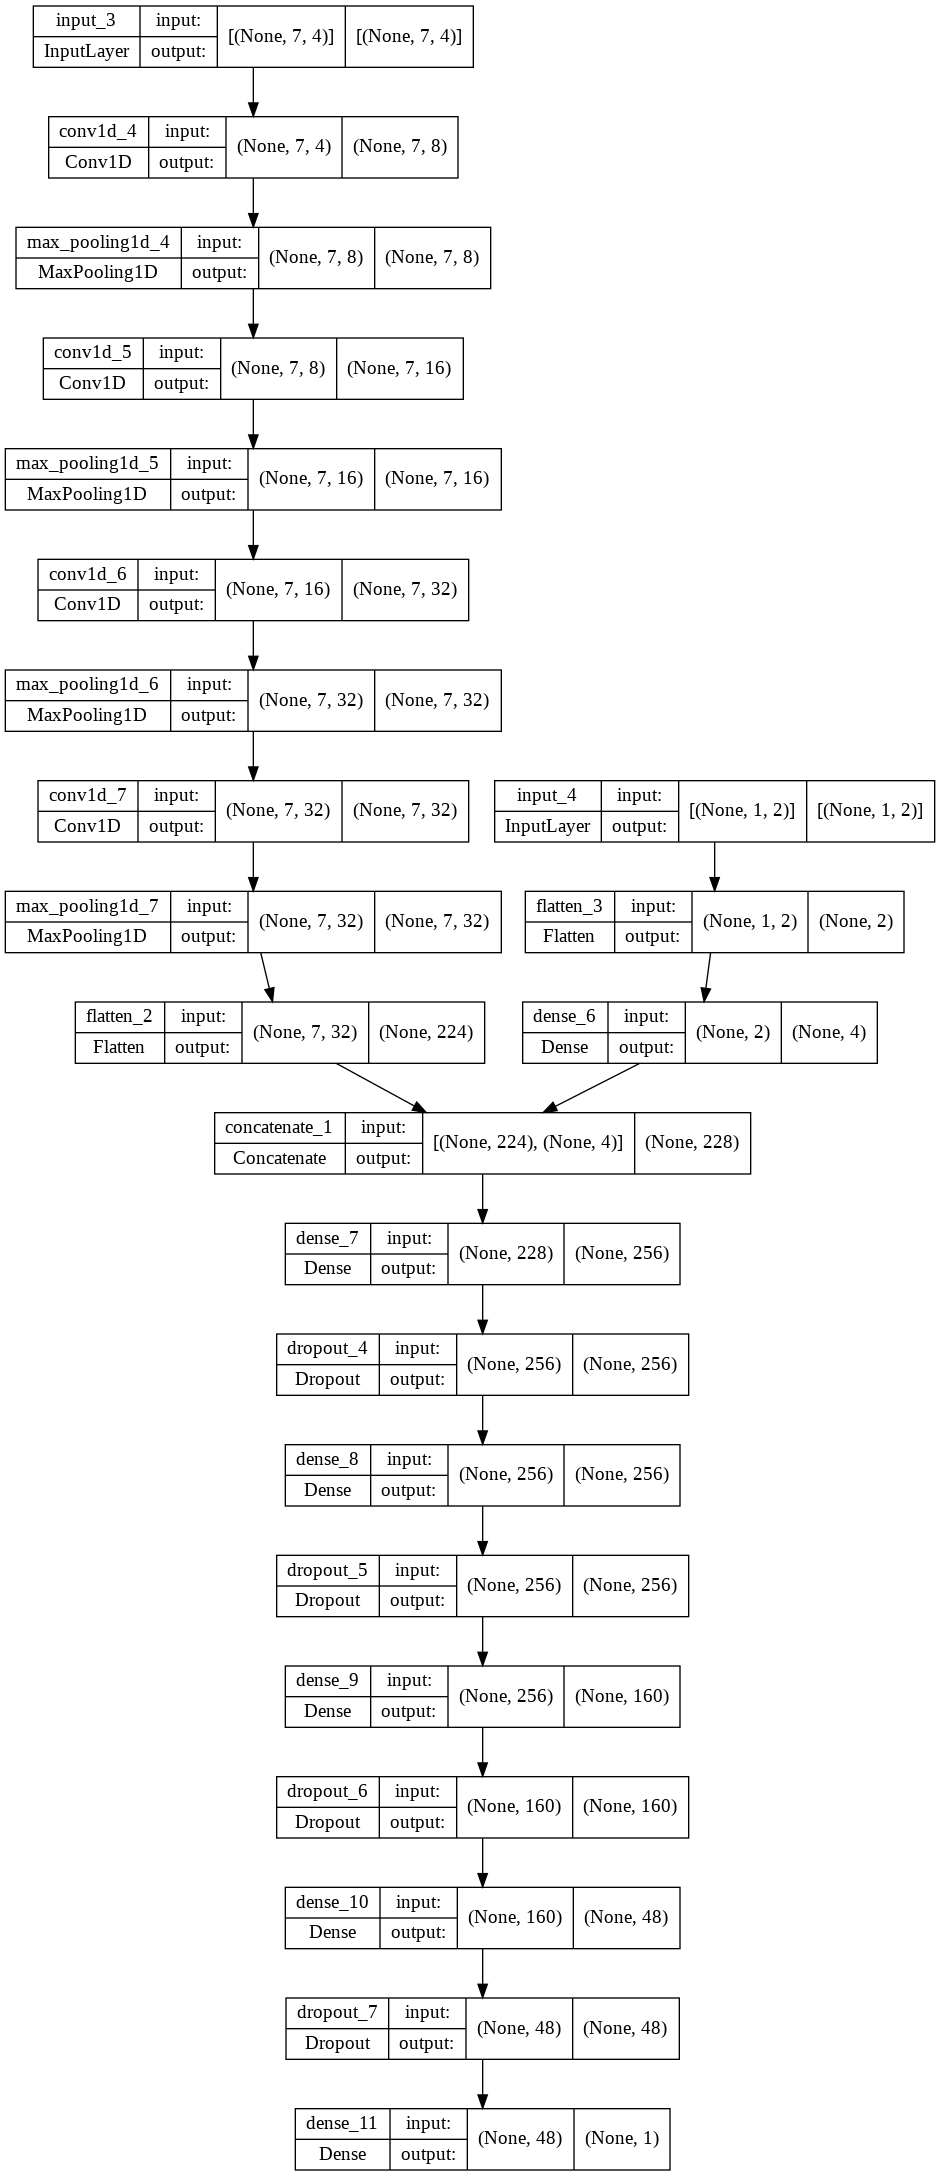

In [ ]:
keras.utils.plot_model(model, "double-headed CNN.png", show_shapes=True)

Print the test accuracy we have achieved

In [ ]:
test_loss, test_acc = model.evaluate([x1_test, x2_test], y_test, batch_size=128)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

2072/2072 [==============================] - 6s 3ms/step - loss: 33782.8438 - mae: 94.7513
Test accuracy: 94.751
Test loss: 33782.844


Print the validation accuracy we have achieved

In [ ]:
val_loss, val_acc = model.evaluate([x1_val, x2_val], y_val, batch_size=2048)
print(f"Val accuracy: {val_acc:.3f}")
print(f"Val loss: {val_loss:.3f}")

130/130 [==============================] - 0s 4ms/step - loss: 33643.6055 - mae: 94.0460
Val accuracy: 94.046
Val loss: 33643.605


Use the model to make predictions on the test data and explicitly store these in a predictions variable

In [ ]:
predictions=model.predict([x1_test,x2_test])
print(predictions.shape)
print(y_test.shape)

(265146, 1)
(265146, 1)


Plot the predictions and the true labels on the same histogram to compare the model's predictions to the ground truth data

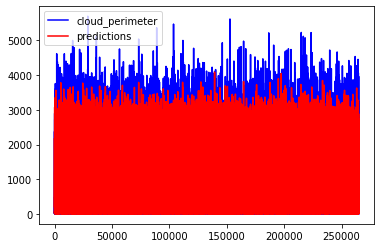

In [ ]:
x_range=range(len(predictions))
predictions=tf.squeeze(predictions)
y_test=tf.squeeze(y_test)
plt.plot(x_range,y_test,color='blue',label='cloud_perimeter')
plt.plot(x_range,predictions,color='red',label='predictions')
plt.legend()
plt.show()

Assert that the removal of all data points with a zero cloud fraction has removed all data points with a zero cloud perimeter (this is a sanity check which checks that the data has been cleaned correctly)

In [ ]:
zero_perimeters = y_test[y_test==0]
print(len(zero_perimeters)/len(y_test))

0.0


Plot a histogram of the predictions

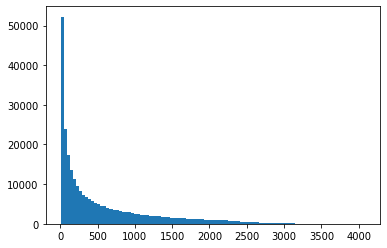

In [ ]:
plt.hist(predictions,bins=100)
plt.show()

Plot the equivalent histogram for the true labels

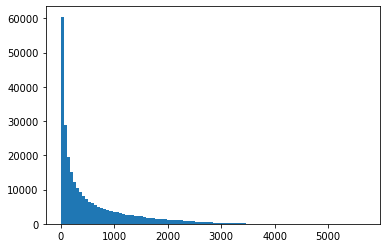

In [ ]:
plt.hist(y_test,bins=100)
plt.show()

Compute the mean average percentage error using the mae of the model

In [ ]:
test_acc/np.mean(y_test)

0.16857004360129152

Find the equivalent mean average percentage error of a naive prediction which just predicts the mean perimeter on the training data for every single test data point

In [ ]:
print(np.mean(np.absolute(y_test - np.mean(y_train)))/np.mean(y_test))

0.9290195120635726


Plot a graph of the train and validation error through the training process (ignoring the initial 2 epochs as these skew the graph)

<function matplotlib.pyplot.show(*args, **kw)>

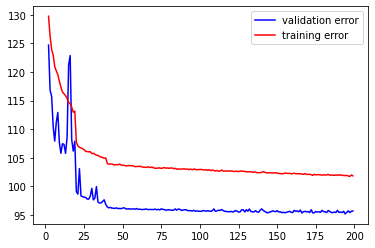

In [ ]:
x=range(200)
plt.plot(x[2:],history.history['val_mae'][2:],color = 'blue',label='validation error')
plt.plot(x[2:],history.history['mae'][2:],color = 'red',label='training error')
plt.legend()
plt.show

Plot a scatter graph of the predictions against the true labels to see if there is a good correlation

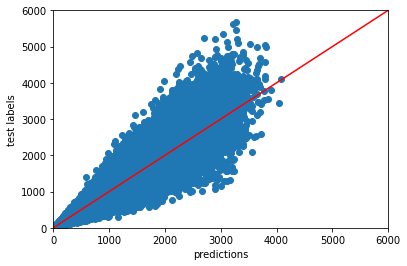

In [ ]:
x=range(6000)
plt.scatter(predictions,y_test)
plt.xlabel('predictions')
plt.ylabel('test labels')
plt.ylim((0,6000))
plt.xlim((0,6000))
plt.plot(x,x,color='red')
plt.show()

We now compare the predictions to a baseline detailed in *Improvements to a prognostic cloud scheme through changes to its cloud erosion parametrization* (Morcrette, 2012) which hypothesises a relationship of $P = \alpha F(1-F)$ where $P$ and $F$ are the perimeter and fraction respectively. The function below finds the optimal alpha from a search range and then computes the mean absolute percentage error using this prediction, for comparison with our model.

In [ ]:
def find_alpha(x2_train,y_train,y_test):
  #set the first mae to be the naive prediction of the mean for all points
  y_test=y_test/16200
  y_train=y_train/16200
  optimal_mae = np.mean(np.absolute(y_test - np.mean(y_train)))
  optimal_alpha = 0
  cloud_fraction = x2_train[:,:,0]
  y_train = y_train[:,0]
  mean_absolute_error_vector = []
  for step in range(100):
        alpha = step/100
        predicted_perimeter = []
        predicted_perimeter = np.multiply(cloud_fraction[:,0],(1-cloud_fraction[:,0]))
        predicted_perimeter = alpha*predicted_perimeter
        predicted_perimeter -= y_train
        predicted_perimeter = predicted_perimeter*(-1)
        mean_absolute_error = np.mean(np.absolute(predicted_perimeter))
        del predicted_perimeter
        mean_absolute_error_vector.append(mean_absolute_error)
        if mean_absolute_error < optimal_mae:
              optimal_mae = mean_absolute_error
              optimal_alpha = alpha
  mean_absolute_error_vector = np.array(mean_absolute_error_vector)
  x=range(100)
  plt.scatter(x,mean_absolute_error_vector)
  plt.show()

  return optimal_mae, optimal_alpha



In [ ]:
def compute_on_test_set(optimal_alpha,x2_test,y_test):
        y_test=y_test/16200
        #work out the error on the test set
        cloud_fraction = x2_test[:,:,0]
        test_predicted_perimeter = []
        y_test = y_test[:,0]
        for j in range(cloud_fraction.shape[0]):
              test_predicted_perimeter.append(optimal_alpha*cloud_fraction[j,0]*(1-cloud_fraction[j,0]))
        test_predicted_perimeter = np.array(test_predicted_perimeter)
        print(test_predicted_perimeter.shape)
        print(y_test.shape)
        final_mae = np.mean(np.absolute(y_test - test_predicted_perimeter))
        return final_mae


The percentage error is found to be 24%

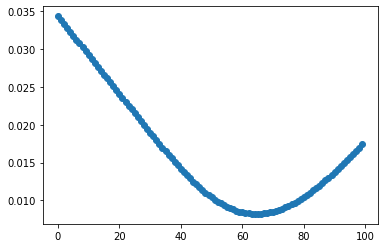

(265146,)
(265146,)
0.008241209252091075
0.64
Average percentage error = 0.23928261791950012


In [ ]:
optimal_mae, optimal_alpha = find_alpha(x2_train,y_train,y_test)
final_mae = compute_on_test_set(optimal_alpha,x2_test,y_test)
print(final_mae)
print(optimal_alpha)
print('Average percentage error =', final_mae/np.mean(y_test/16200))

We plot a graph of cloud fraction against normalised cloud perimeter and overlay the derived relationship over the top. It is clear that this is a good (essentially optimal) reflection of the relationship between cloud fraction and cloud perimeter. Therefore, our neural network must be finding more useful data in the height and atmospheric variables arrays with which to lower the error and make better predictions

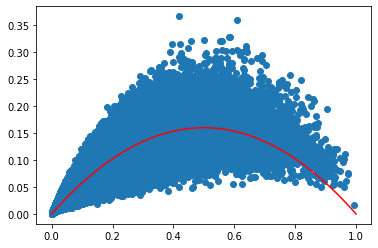

In [ ]:
x=np.linspace(0,1,100)
plt.scatter(x2_test[:,0,0],y_test/16200)
plt.plot(x,0.64*x*(1-x),color='red')
plt.show()